# トピックモデルでの予測

In [89]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import japanize_matplotlib

import numpyro
import numpyro.distributions as dist

import jax
import jax.numpy as jnp

import arviz as az
import seaborn as sns

from numpyro.contrib.control_flow import scan

In [90]:
numpyro.set_platform('cpu')
numpyro.set_host_device_count(5)

In [91]:
num_step = 100
step_size = 0.1
np.random.seed(1)

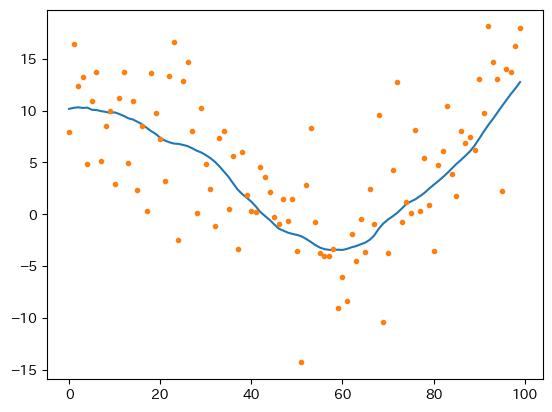

In [92]:
z = np.random.randn(num_step) * step_size
b = np.cumsum(z)
u = np.cumsum(b)
sigma = 5
c = 10
e = np.random.randn(num_step)

u = u + c
y = u + e * sigma

plt.figure()
plt.plot(u)
plt.plot(y, '.')

In [93]:
t = np.arange(len(y))
y = jnp.array(y)

In [94]:
# scan関数を用いたランダムウォーク関数の定義
def gaussian_random_walk(name, num_steps, scale=1.0):

    def transition_fn(u_prev, t):
        
        u_curr = numpyro.sample(name, dist.Normal(u_prev, scale))
        
        return u_curr, u_curr
    
    t = jnp.arange(num_steps)
    
    _, u = scan(transition_fn, 0.0, t)
    
    return u

## モデリング
- 基本的には前の章と同じだが、予測を行うために、ランダムウォークの関数を自前のものに置き換えているのと`numpyro.handlers.condition`を使っている

In [95]:
def model(y_obs, future=0):
    
    num_steps = len(y_obs)

    # ランダムウォーク変数の分散パラの事前分布
    sd_b = numpyro.sample("sd_b", dist.HalfNormal(10))
    
    # ランダムウォーク
    b = gaussian_random_walk("b", num_steps + future, scale=sd_b)
    
    #トレンドモデルの初期値（バイアス）の事前分布
    c = numpyro.sample("c", dist.Normal(10))

    # ランダムトレンド（確率変数ではない）
    u = numpyro.deterministic("u", jnp.cumsum(b) + c)
    
    sd_y = numpyro.sample("sd_y", dist.HalfNormal(10))
    

    #観測モデル（スムーストレンド）
    with numpyro.handlers.condition(data={"y":y_obs}):
        
        def observer_fn(carry, uu):
    
            y = numpyro.sample("y", dist.Normal(uu, sd_y))
    
            return carry, y

        
        _, y = scan(observer_fn, None, u)
    
    if future > 0:
        # 予測分には別途名前付けとく
        numpyro.deterministic("y_pred", y[-future:])

In [96]:
nuts = numpyro.infer.NUTS(model, target_accept_prob=0.95)
mcmc = numpyro.infer.MCMC(nuts, num_warmup=1000, num_samples=1000, num_chains=5)

mcmc.run(jax.random.PRNGKey(1), y)

trace = mcmc.get_samples()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/home/inoma/.local/share/virtualenvs/Py_bayes-Xd0WuMm8/lib/python3.8/site-packages/numpyro/contrib/control_flow/scan.py:264: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  length = tree_flatten(xs)[0][0].shape[0]
/home/inoma/.local/share/virtualenvs/Py_bayes-Xd0WuMm8/lib/python3.8/site-packages/numpyro/contrib/control_flow/scan.py:264: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  length = tree_flatten(xs)[0][0].shape[0]


In [97]:
idata = az.from_numpyro(mcmc)

/home/inoma/.local/share/virtualenvs/Py_bayes-Xd0WuMm8/lib/python3.8/site-packages/numpyro/contrib/control_flow/scan.py:264: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  length = tree_flatten(xs)[0][0].shape[0]


In [98]:
az.summary(idata, var_names=["c", "sd_b", "sd_y"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c,10.083,0.823,8.509,11.610,0.013,0.009,4245.0,3747.0,1.00
sd_b,0.095,0.040,0.040,0.162,0.005,0.004,79.0,77.0,1.07
sd_y,4.744,0.358,4.095,5.434,0.005,0.004,5422.0,3347.0,1.00


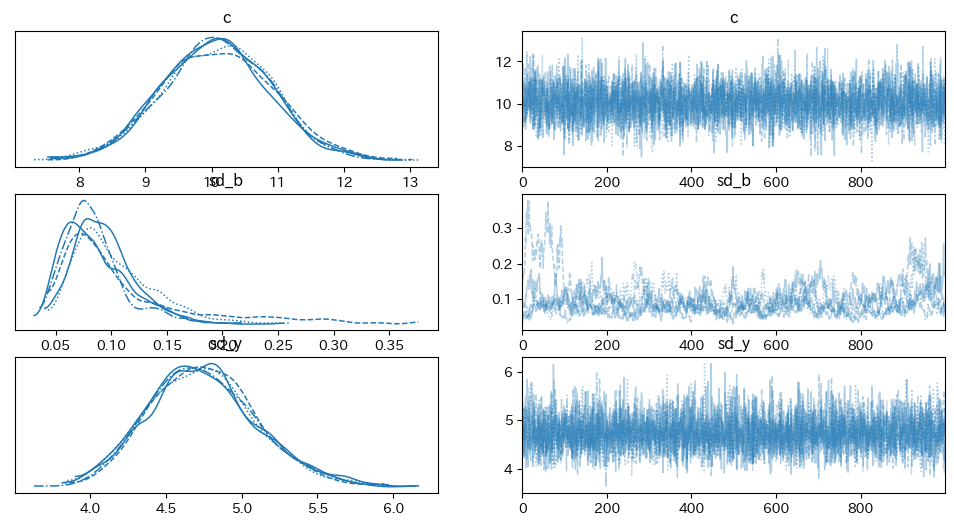

In [99]:
az.plot_trace(idata, var_names=["c", "sd_b", "sd_y"]);

In [100]:
u_sampled = trace["u"]

In [101]:
mu = jnp.mean(u_sampled,0)
pi = jnp.percentile(u_sampled, jnp.array([5, 95]), 0)

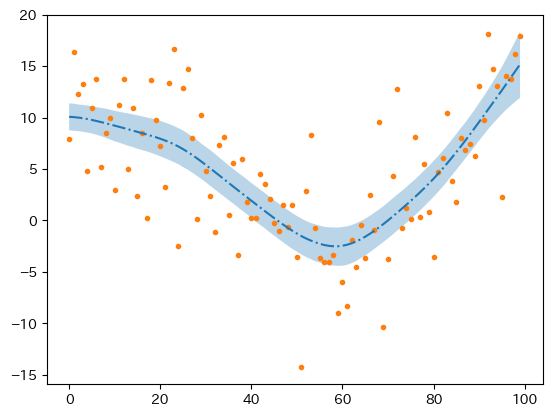

In [102]:
plt.plot(t, y, ".", color="C1")

plt.plot(t, mu, "-.")
plt.fill_between(t, pi[0,:], pi[1,:], alpha = 0.3);

In [103]:
observer_steps = len(y)
future_steps = 50

In [104]:
predictive = numpyro.infer.Predictive(model, trace, return_sites=["y_pred"])
samples = predictive(jax.random.PRNGKey(2), y, future=future_steps)

/home/inoma/.local/share/virtualenvs/Py_bayes-Xd0WuMm8/lib/python3.8/site-packages/numpyro/contrib/control_flow/scan.py:264: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  length = tree_flatten(xs)[0][0].shape[0]


In [105]:
y_pred = samples["y_pred"]
t_pred = np.arange(observer_steps, observer_steps + future_steps)

In [106]:
mu_pred = jnp.mean(y_pred, 0)
pi_pred = jnp.percentile(y_pred, jnp.array([5, 95]), 0)

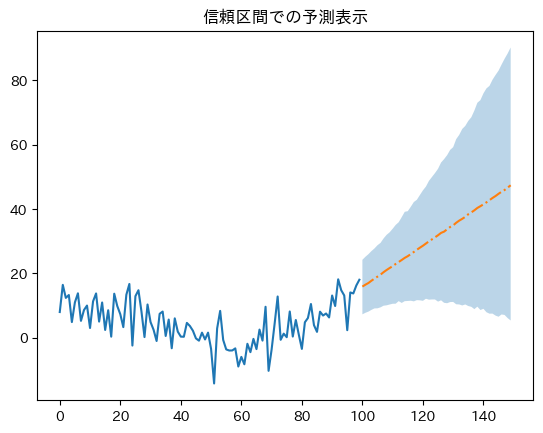

In [107]:
plt.plot(t, y)

plt.plot(t_pred, mu_pred, "-.")
plt.fill_between(t_pred, pi_pred[0, :], pi_pred[1, :], alpha=0.3)
plt.title("信頼区間での予測表示");

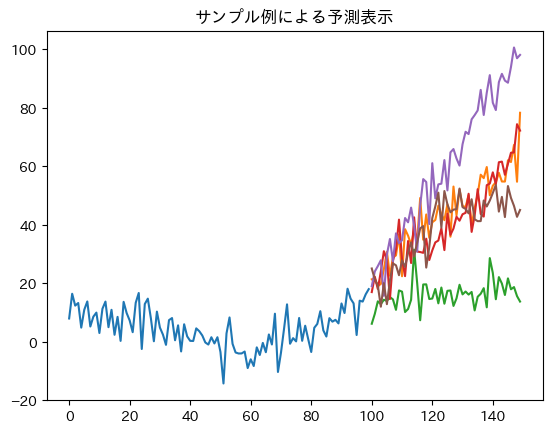

In [108]:
plt.figure()
plt.plot(t, y)
plt.plot(t_pred, y_pred[:5,].T)
plt.title("サンプル例による予測表示");

# 季節変動成分
### データロード

In [109]:
from statsmodels.datasets import elec_equip
from dateutil.relativedelta import relativedelta
data = elec_equip.load(as_pandas=True).data

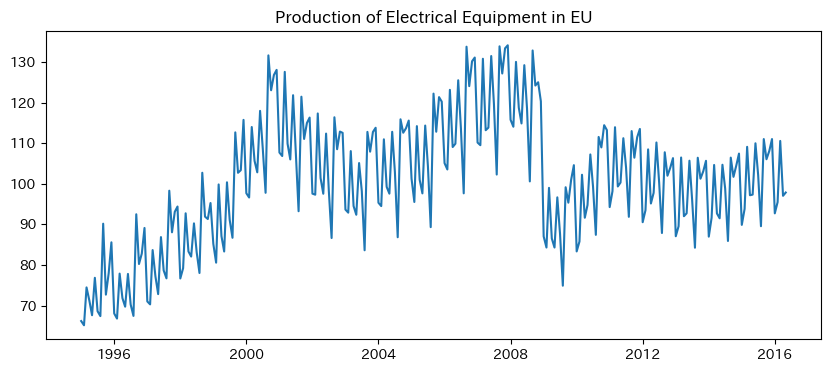

In [110]:
plt.figure(figsize=(10, 4))
plt.plot(data)

plt.title('Production of Electrical Equipment in EU');

In [111]:
t_obs = data.index
y_obs = data.values.flatten()
y_obs = jax.numpy.array(y_obs)

### モデリング
- 一定の周期で変動する成分がデータに混ざっていると仮定して、これまでにやったトレンド成分に足し合わせる
    - 具体的には,三角関数などで周波数の違う複数の関数を作っておいて、その重み付き和をトレンドに加える
        - 重みパラメタを確率変数として、その事後分布を求める

#### 季節変動成分
$$
s(t) = \sum_{k=1}^N a_k\cos \left(\frac{2\pi k t}{T}\right) + b_k \sin \left(\frac{2\pi k t}{T} \right)
$$

$$
a_k, b_k:重みパラメタ
$$

$$
T:最大周期 \\
N:混ぜ合わせ成分数(N/Tが最小周期)
$$

In [112]:
# 周波数の違う余弦波と正弦波を1stepあたり複数(num_basis)個、num_step分作る
# 周期:period　（これを最大周期として、これより小さい周期の波を作る）
def fourier_basis(num_steps, num_basis, period):
    t = jnp.arange(num_steps)
    x = 2*jnp.pi *jnp.arange(1, num_basis + 1)/period # 周波数
    x = x*t[:, None]
    
    x = jnp.concatenate((jnp.cos(x), jnp.sin(x)), axis=1) # shape = num_steps × 2*num_basis
    print(x.shape,num_steps, num_basis)
    return x

In [113]:
# 各周波数成分に対する重みの確率変数を作って重み付き和を決定変数に追加
def seasonality_comp(name, num_steps, num_basis, period):
    
    basis = fourier_basis(num_steps, num_basis, period)
    
    r = numpyro.sample("r", dist.Normal(0, 10), sample_shape=(2 * num_basis,))
    
    ss = numpyro.deterministic(name, jnp.dot(basis, r))
    
    return ss

In [114]:
#ランダムウォーク関数
def gaussian_radom_walk(name, num_steps, scale=1.0):
    
    def transition_fn(u_prev, t):
        u_curr = numpyro.sample(name, dist.Normal(u_prev, scale))
        
        return u_curr, u_curr
    
    _, u = scan(transition_fn, 0.0, jnp.arange(num_steps))
    
    return u

In [115]:
def model(y_obs, future=0):
    
    num_steps = len(y_obs)
    
    # ランダムウォークのガウスノイズの分散の事前分布
    sd_b = numpyro.sample("sd_b", dist.HalfNormal(10))    
    # ランダムウォーク
    b = gaussian_radom_walk("b", num_steps+future) * sd_b

    # スムーストレンドのバイアスの分布
    c = numpyro.sample("c", dist.HalfNormal(10))
    # スムーストレンド
    u = numpyro.deterministic("smooth_trend", jnp.cumsum(b) + c)
    
    # 季節変動成分
    s = seasonality_comp("seasonality", num_steps + future, period=12, num_basis=5)
    
    v = u + s #スムーストレンドに季節変動成分をがっちゃんこ
    
    # 観測モデルのノイズの分散の事前分布
    sd_y = numpyro.sample("sd_y", dist.HalfNormal(10))
    # 観測モデル
    with numpyro.handlers.condition(data={"y":y_obs}):
        def observer_fn(carry, x):
            y = numpyro.sample("y", dist.Normal(x, sd_y))
        
            return carry, y
        _, y = scan(observer_fn, None, v)
    
    if future > 0:
        numpyro.deterministic("y_pred", y[-future:])
        

In [116]:
nuts = numpyro.infer.NUTS(model, target_accept_prob=0.95)
mcmc = numpyro.infer.MCMC(nuts, num_warmup=1000, num_samples=1000, num_chains = 5)
mcmc.run(jax.random.PRNGKey(11), y_obs)

trace = mcmc.get_samples()

/home/inoma/.local/share/virtualenvs/Py_bayes-Xd0WuMm8/lib/python3.8/site-packages/numpyro/contrib/control_flow/scan.py:264: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  length = tree_flatten(xs)[0][0].shape[0]


(257, 10) 257 5
(257, 10) 257 5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/home/inoma/.local/share/virtualenvs/Py_bayes-Xd0WuMm8/lib/python3.8/site-packages/numpyro/contrib/control_flow/scan.py:264: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  length = tree_flatten(xs)[0][0].shape[0]


(257, 10) 257 5


/home/inoma/.local/share/virtualenvs/Py_bayes-Xd0WuMm8/lib/python3.8/site-packages/numpyro/contrib/control_flow/scan.py:264: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  length = tree_flatten(xs)[0][0].shape[0]


(257, 10) 257 5


In [117]:
idata = az.from_numpyro(mcmc)

(257, 10) 257 5
(257, 10) 257 5


/home/inoma/.local/share/virtualenvs/Py_bayes-Xd0WuMm8/lib/python3.8/site-packages/numpyro/contrib/control_flow/scan.py:264: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  length = tree_flatten(xs)[0][0].shape[0]


In [118]:
az.summary(idata, var_names = ["c", "sd_b", "sd_y"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c,71.277,1.844,67.991,74.894,0.033,0.023,3163.0,3069.0,1.00
sd_b,0.442,0.068,0.321,0.568,0.003,0.002,533.0,1159.0,1.01
sd_y,3.031,0.154,2.737,3.328,0.003,0.002,3301.0,3524.0,1.00


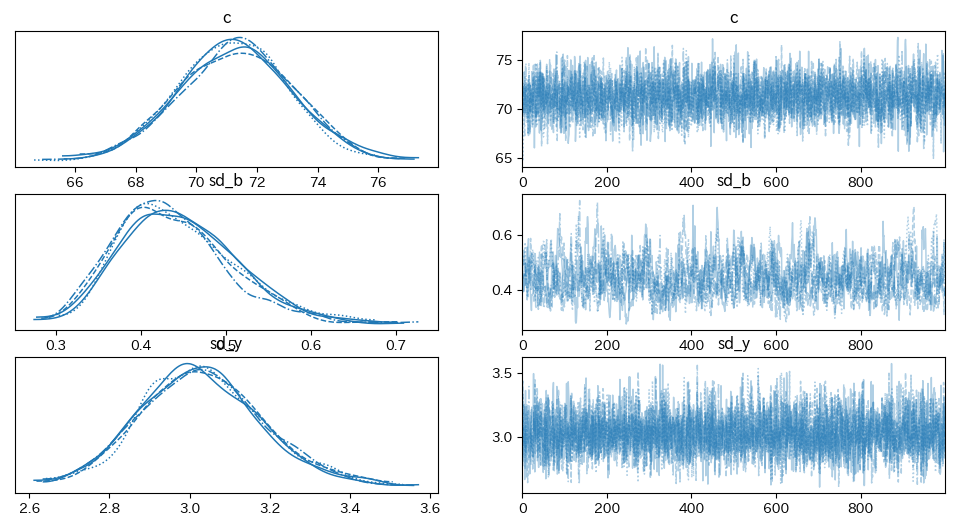

In [119]:
az.plot_trace(idata, var_names=["c", "sd_b", "sd_y"]);

### フィルタリング

In [120]:
smooth_trend = trace["smooth_trend"]

In [121]:
mu = jnp.mean(smooth_trend, 0)
pi = jnp.percentile(smooth_trend, np.array([5, 95]), 0)

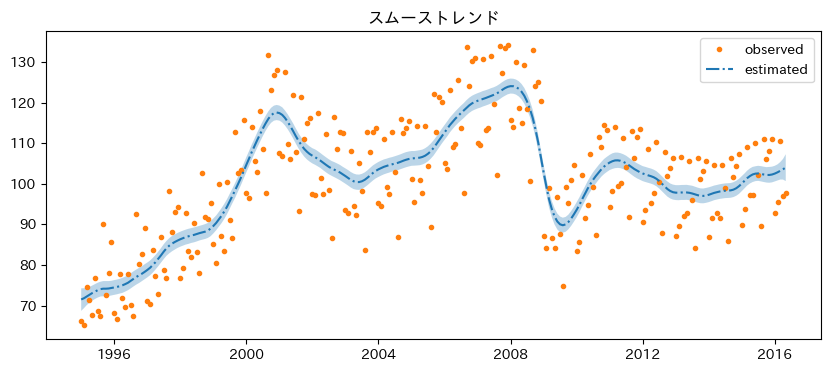

In [122]:
plt.figure(figsize=(10, 4))

plt.plot(t_obs, y_obs, ".", color = "C1", label = "observed")
plt.plot(t_obs, mu, "-.", label="estimated")
plt.fill_between(t_obs, pi[0,:], pi[1, :], alpha=0.3)

plt.title("スムーストレンド")
plt.legend()
plt.show()

In [123]:
seasonality = trace["seasonality"]

In [124]:
mu = jnp.mean(seasonality, 0)
pi = jnp.percentile(seasonality, np.array([5, 95]), 0)

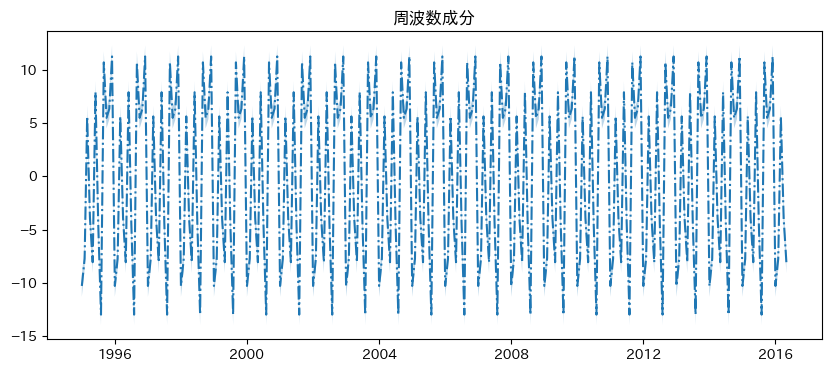

In [125]:
plt.figure(figsize=(10, 4))

plt.plot(t_obs, mu, "-.")
plt.fill_between(t_obs, pi[0, :], pi[1, :], alpha=0.3)

plt.title("周波数成分")
plt.show()

## 予測

In [126]:
future = 24

In [127]:
predictive = numpyro.infer.Predictive(model, trace)
ppc_samples = predictive(jax.random.PRNGKey(2), y_obs, future=future)

/home/inoma/.local/share/virtualenvs/Py_bayes-Xd0WuMm8/lib/python3.8/site-packages/numpyro/contrib/control_flow/scan.py:264: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  length = tree_flatten(xs)[0][0].shape[0]


(281, 10) 281 5


In [128]:
y_pred = ppc_samples["y_pred"]
t_pred = pd.date_range(t_obs[-1] + relativedelta(month=1), periods=future, freq="MS")

In [129]:
mu_pred = jnp.mean(y_pred, 0)
pi_pred = jnp.percentile(y_pred, np.array([5, 95]),0)

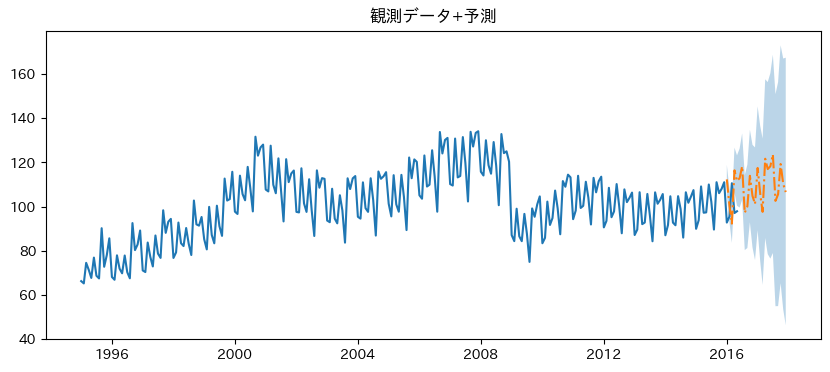

In [130]:
plt.figure(figsize=(10, 4))
plt.plot(t_obs, y_obs, "-")
plt.plot(t_pred, mu_pred, "-.")
plt.fill_between(t_pred, pi_pred[0,:], pi_pred[1,:], alpha = 0.3)
plt.title("観測データ+予測")
plt.show()

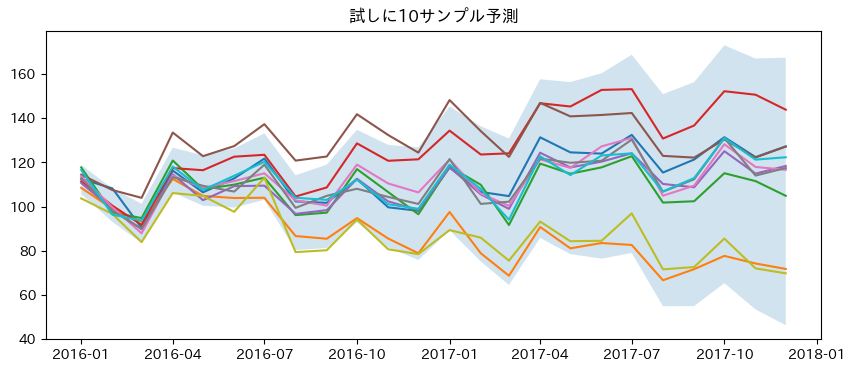

In [131]:
plt.figure(figsize=(10, 4))

plt.fill_between(t_pred, pi_pred[0,:], pi_pred[1, :], alpha=0.2)
plt.plot(t_pred, y_pred[:10, ].T)

plt.title("試しに10サンプル予測")
plt.show()